In [2]:
import PIL.Image as pil_image
import io
import numpy as np
import cv2
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter
import torch
from random import randint


from ct_utils import ctload, ctshow, ctsave

In [1]:
DATASET_DIR = "COVID-CTset"

In [3]:
def get_relevant_scans_dir(base_dir):
    dir_names = []
    dir_names_normal = []

    for root, dirnames, filenames in os.walk(base_dir):
        for filename in filenames:
            full_path = os.path.dirname(os.path.join(root, filename))
            dir_names.append(full_path)
            if 'normal' in full_path:
                dir_names_normal.append(full_path)
                
    img_per_scan_counter = Counter(dir_names_normal)
    wanted_scans_dirs = [scan_dir for scan_dir in img_per_scan_counter if img_per_scan_counter[scan_dir] == 35]
    return wanted_scans_dirs


In [4]:
def load_random_slices(scan_dir, slices_count):
    slices_paths = sorted(os.listdir(scan_dir))
    length = len(slices_paths)
    if length < slices_count:
        raise ValueError(f"count ({slices_count}) larger than number of files in dir ({length})") 
    ind = randint(0, length - slices_count)
    chosen_slices_paths =  slices_paths[ind:ind + slices_count]
    return np.array([ctload(os.path.join(scan_dir, slice_path)) for slice_path in chosen_slices_paths])

In [5]:
c_path = get_relevant_scans_dir(DATASET_DIR)[0]
loaded = load_random_slices(c_path, 4)
loaded.shape

(4, 512, 512)

In [67]:
def generate_mask(img_dims, mask_dims, num_masked_slices, padding_slices):
    mask = torch.zeros((num_masked_slices + padding_slices * 2, img_dims[0], img_dims[1]))
    x_ind = randint(0, img_dims[0] - mask_dims[0])
    y_ind = randint(0, img_dims[1] - mask_dims[1])
    mask[padding_slices: -padding_slices,x_ind:x_ind + mask_dims[0],y_ind:y_ind + mask_dims[1]] = 1
    return torch.gt(mask, torch.zeros_like(mask))

In [114]:
generate_mask((5, 5), (3, 3), 3, 1)

torch.Size([3, 3, 3])
torch.Size([3, 5, 5])


tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])

In [71]:
from torch.utils.data import Dataset
from torchvision import transforms

class CTDataset(Dataset):
  def __init__(self, dir_path, mask_dims=(64, 64), num_masked_slices=3, padding_slices=2, transform=transforms.ToTensor(), normal_only=True):
    self._scans_paths = get_relevant_scans_dir(dir_path)
    self._mask_dims = mask_dims
    self._num_masked_slices = num_masked_slices
    self._padding_slices = padding_slices
    # self._transform = transform
    # Cuurently ignore  transform and noraml_only

  def __len__(self):
    """
    Returns:
      the length of the dataset. 
    """
    return len(self._scans_paths)


  def __getitem__(self, idx):
    raw_scan = load_random_slices(self._scans_paths[idx], self._num_masked_slices + self._padding_slices * 2)
    scan = torch.Tensor(raw_scan.astype(np.int32))
    print(scan.shape)
    mask = generate_mask(scan.shape[1:], self._mask_dims, self._num_masked_slices, self._padding_slices)
    masked = scan.clone()
    masked = masked.masked_fill_(mask, 0)
    return {"orig": scan, "mask": mask, "masked": masked}


In [75]:
dataset = CTDataset(DATASET_DIR)

datapoint = dataset[0]
datapoint['mask'].shape

torch.Size([7, 512, 512])


torch.Size([7, 512, 512])

torch.Size([7, 512, 512])
torch.Size([7, 512, 512])


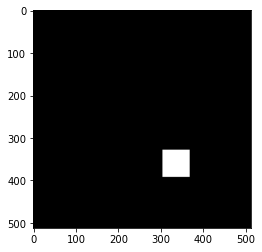

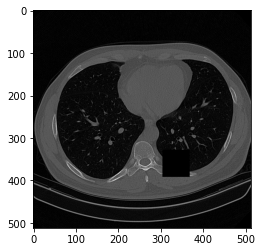

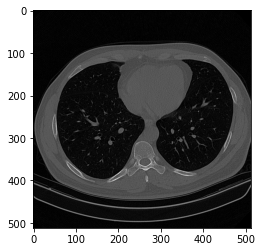

In [76]:
print(datapoint['masked'].shape)
print(datapoint['mask'].shape)

cur_mask = datapoint['mask'][3]
cur_img = datapoint['masked'][3]
cur_orig = datapoint['orig'][3]
ctshow(cur_mask)
ctshow(cur_img)
ctshow(cur_orig)